In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [15]:
#Load a base file for simulation parameters: 
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


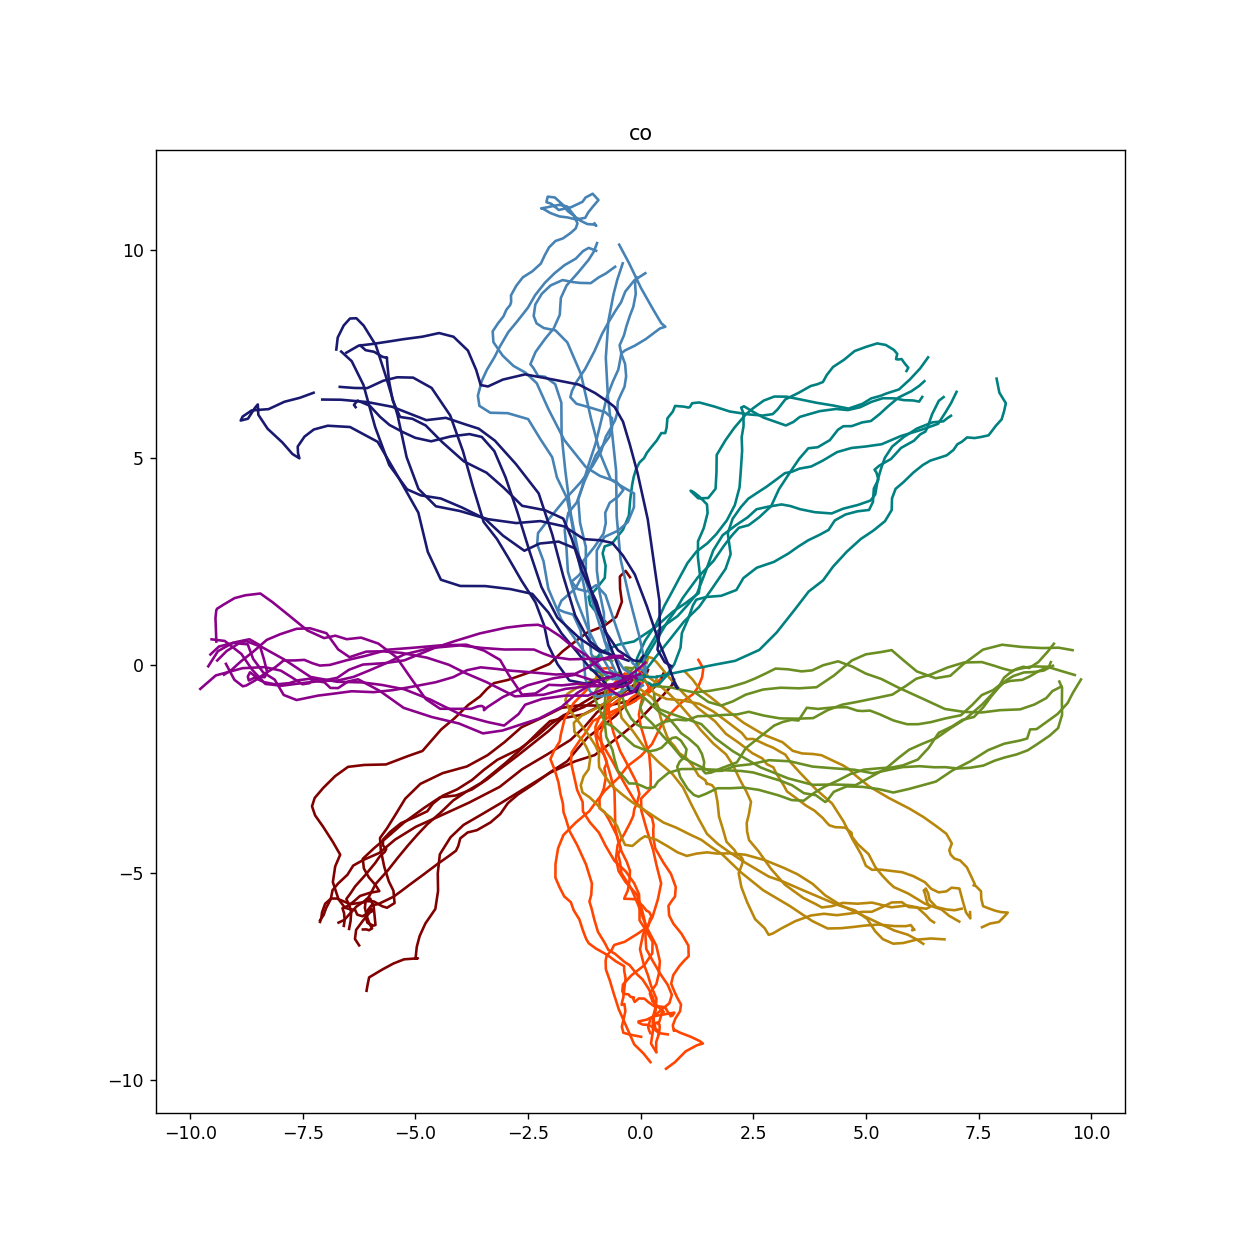

<IPython.core.display.Javascript object>


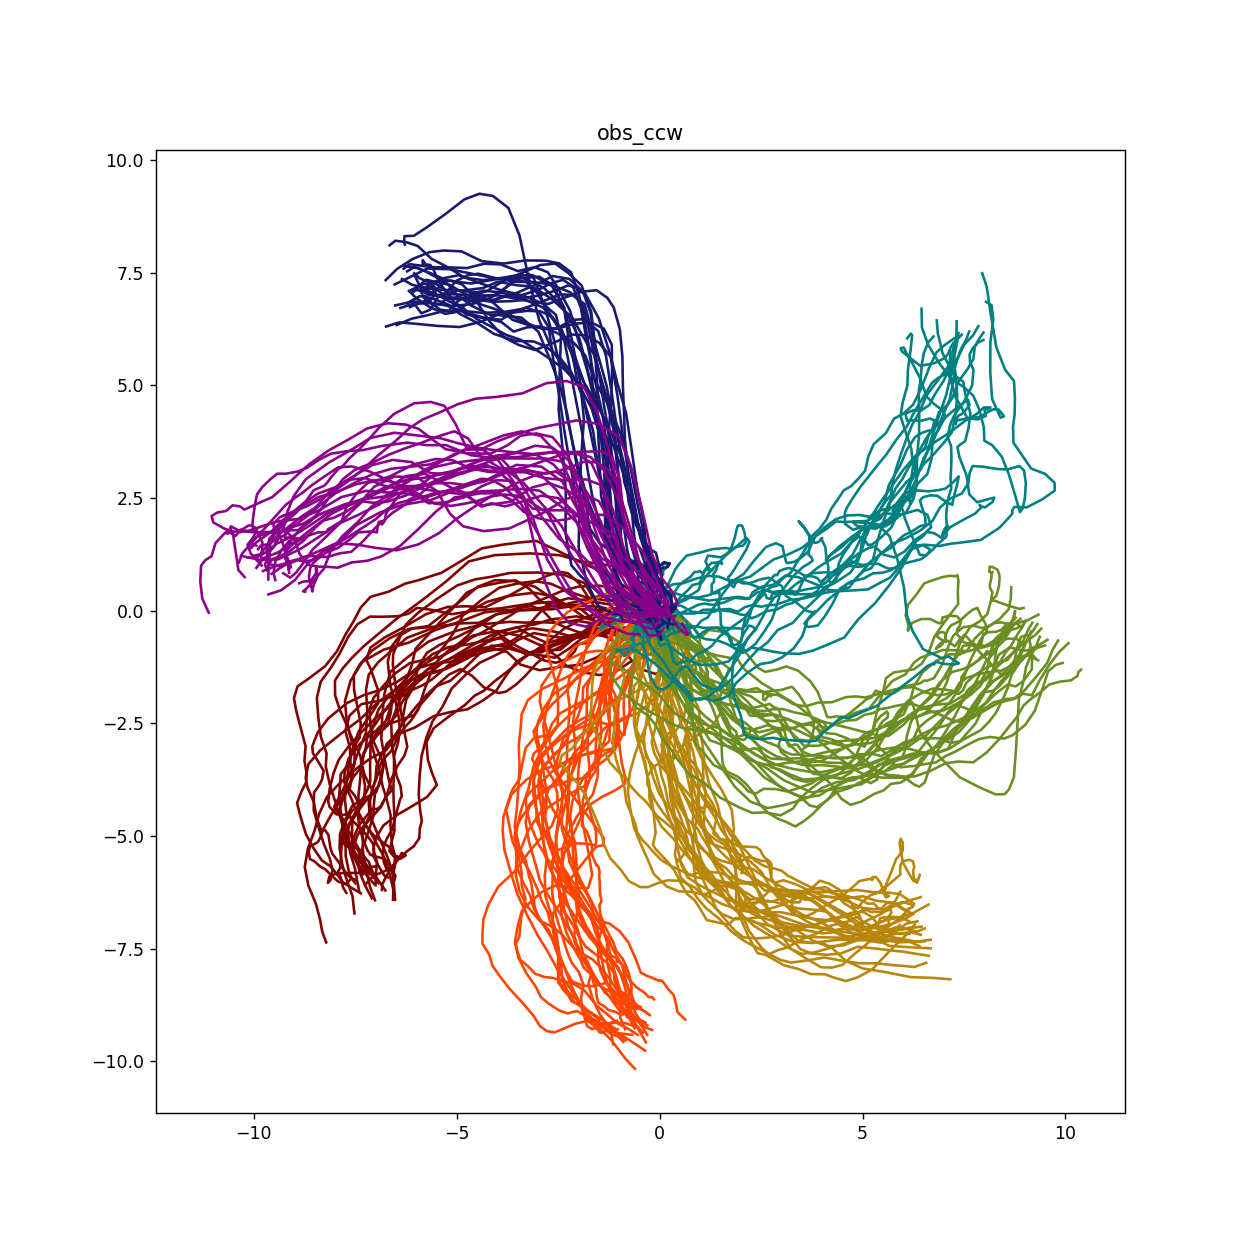

<IPython.core.display.Javascript object>


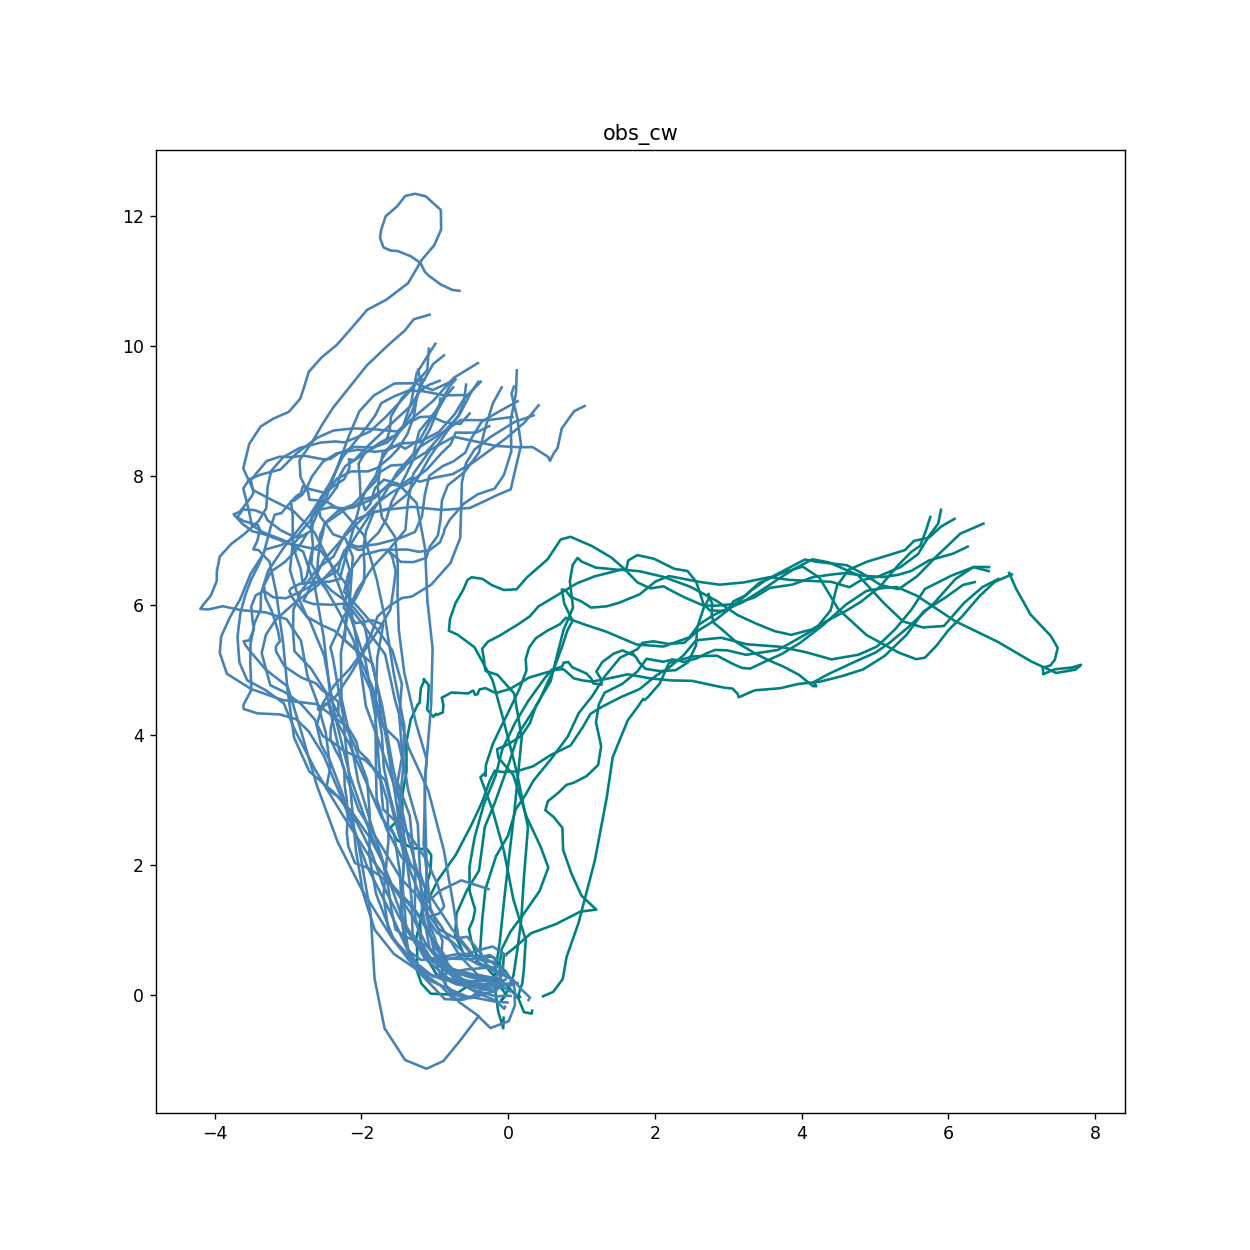

In [16]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

### Define useful functions

In [255]:
def plot_norm_u(norm_u_df, model_list, target_list, task_rot_list):
    #Plot norm u for all movements: 
    # model_list = ['n_do', 'n_o', 'n_null']
#     model_list = ['n_do', 'n_null']
    task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
    plt.figure(figsize=(3,6))
    for target in target_list:
        for task in task_rot_list:

            x_plot = []
            y_plot = []
            for i,m in enumerate(model_list):
                x_plot.append(i)
                sel = \
                (norm_u_df['target']==target)\
                &(norm_u_df['task']==task)\
                &(norm_u_df['model']==m)
                y_i = float(norm_u_df.loc[sel,'norm_u'])
                y_plot.append(y_i)

            plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)
        
            
    plt.xticks(range(len(model_list)), model_list)
    plt.ylabel('norm u')
    plt.title('norm u')
    plt.xlim(np.array([0, len(model_list)])-0.5)    

In [256]:
def pool_u_cond(norm_u_df, model_list, target_list, task_rot_list):
    u_pool = {}
    for m in model_list:
        sel_m = (norm_u_df['model'] == m)
        u_pool[m] = np.array(norm_u_df['norm_u'][sel_m])
        u_pool[m, 'mean'] = np.mean(u_pool[m])
    return u_pool

### Load data

In [980]:
#Done: 2

In [981]:
#load data
#--------------------------------------------------------------
a = 'jeev'
d = 3
#--------------------------------------------------------------
save_home = r'D:\DATA\bmi_co_obs_backup'

use_default_F = False
use_decoder_null = True
use_noise = True


load_file = save_file = 'lqr_sim_test_F'


if use_default_F:
    load_file += '_default'
if use_decoder_null:
    load_file += '_decoder_null'
if use_noise:
    load_file += '_noisy'
load_file += '.pkl'
print(load_file)


data_dir = os.path.join(save_home, a, str(d))
data_path = os.path.join(data_dir, load_file)

with open(data_path, 'rb') as f: 
    data = pickle.load(f)   
    
for (k,v) in data.items():
    exec(k+'=v') 

lqr_sim_test_F_decoder_null_noisy.pkl


In [982]:
#data.keys()

In [983]:
#Kn.shape

In [984]:
# print(bn_m)
test = np.dot(Kn, np.dot(An_m, bn_m))
test = test[:4]
test = test/np.linalg.norm(test)
test

matrix([[ 0.],
        [ 0.],
        [-1.],
        [ 0.]])

In [985]:
test = np.array(F[:4,-1])
test = test/np.linalg.norm(test)
test

array([ 0.        ,  0.        , -0.04055117, -0.99917746])

<IPython.core.display.Javascript object>


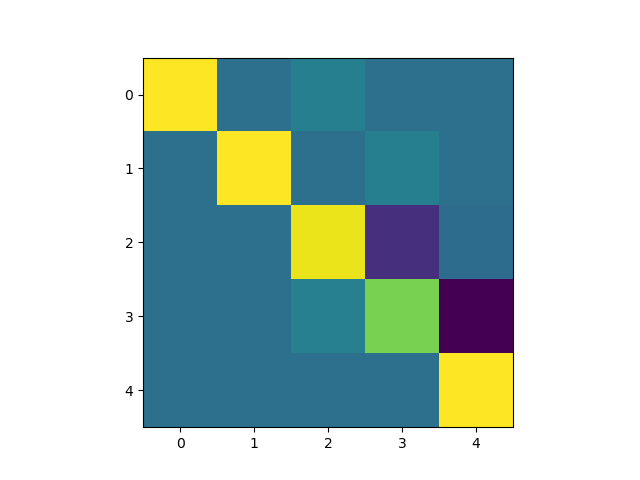

In [986]:
plt.figure()
plt.imshow(F)

In [987]:
#norm_u_df.head()

In [988]:
#data.keys()

In [989]:
#task_rot_list

In [990]:
use_noise

True

In [991]:
norm_u_df_n.head()

,norm_u,target,task,model
0,1.993933,0,0.0,n_do
1,1.986211,0,0.0,n_null
2,1.995896,0,0.0,n_o
3,1.980603,0,0.0,n_d
4,3.192132,0,1.1,n_do


<IPython.core.display.Javascript object>


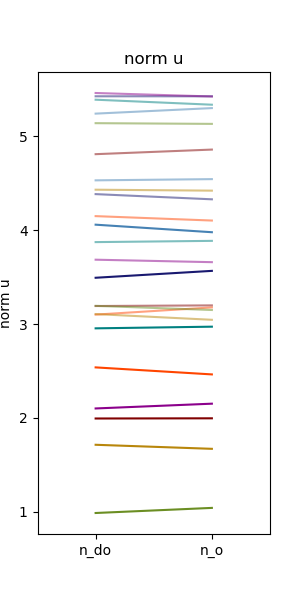

In [992]:
#Plot norm u for all movements:
if use_noise:
    norm_u_df = norm_u_df_n
else:
    norm_u_df = norm_u_df_nl

model_list_analyze = ['n_do', 'n_o']
# model_list_analyze = ['n_d', 'n_null']
# model_list_analyze = ['n_o', 'n_null']

plot_norm_u(norm_u_df, model_list_analyze, target_list, [0,1.1,1.2])

In [993]:
u_pool = pool_u_cond(norm_u_df, model_list, target_list, task_rot_list)

In [994]:
# u_pool

In [995]:
m0 = 'n_do'
m1 = 'n_o'
# m0 = 'n_d'
# m1 = 'n_null'

print(u_pool[m0, 'mean'], u_pool[m1, 'mean'])
print(100*u_pool[m0, 'mean']/u_pool[m1, 'mean'])

(3.706578973602319, 3.7013920689574555)
100.14013388877025


<IPython.core.display.Javascript object>


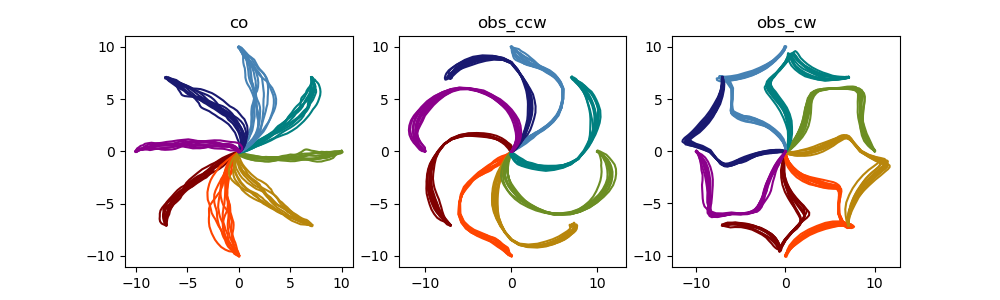

In [996]:
#Plot cw vs ccw trials, to confirm:
if use_noise:
    df_lqr = df_lqr_n
else:
    df_lqr = df_lqr_nl

m = 'n_do'
plot = {}
plot['size'] = (10,3)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

num_trials_plot = 10
plt.figure(figsize=plot['size'])
for i,task in enumerate(task_rot_list): 
    plt.subplot(1,3,i+1)
    plt.title(task_rot_label[i])    
    for target in range(num_targets):    
        sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
        df_sel = df_lqr[sel]
        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.where(df_sel['bin_end']==0)[0]
        trial_bound = np.vstack((trial_start,trial_stop)).T
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:num_trials_plot,:]: #trial_bound[0:1,:]:
#             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
            color = target_color[target]
            plt.plot(x,y,'-',color=color)

In [997]:
if use_noise:
    move_lqr=move_lqr_n
else:
    move_lqr=move_lqr_nl

In [998]:
move_lqr[target,task,m].keys()

['A',
 'Q_f',
 'sim_len',
 'B',
 'K_list',
 'move_len',
 'state_noise_list',
 'state_e_list',
 'Q',
 'R',
 'u_list',
 'state_init',
 'horizon_list',
 'state_list',
 'A_e_list',
 'state_T_list']

In [999]:
move_lqr[target,task,m]['state_list'][0].shape

(26L, 39L)

<IPython.core.display.Javascript object>


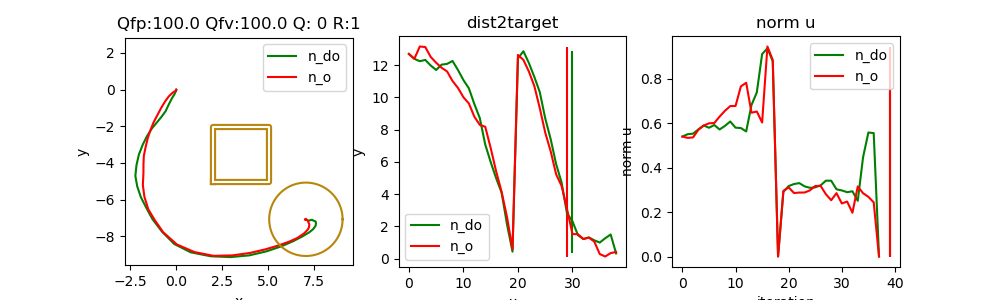

In [1000]:
#SHOW ONE EXAMPLE TRIAL DIAGNOSTICS: 

#Plot each on the same subplot
#Visualize results: 
m = 'n_do'
target = 2
task = 1.1  #1.1 #1.2
horizon_list = move_lqr[target,task,m]['horizon_list']
i_trial = 0


#hardcoded:
if task >0:
    num_seg = 2
else:
    num_seg = 1    
if task == 0: 
    seg_x = np.array([[0], [horizon_list[0]]])
else:
    seg_x = np.array([[0, horizon_list[0]], [horizon_list[0]-1, sum(horizon_list)-2]])

state_T_list = move_lqr[target,task,m]['state_T_list']
state_T_mat = np.array(state_T_list).squeeze().T
if task==0:
    state_T_mat = state_T_mat.reshape((-1,1))
state_T_da = xr.DataArray(state_T_mat, coords={'v':n_list+kin_var+offset_var, 'seg':range(num_seg)},\
                           dims=['v', 'seg'])    

model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k', 'n_d':'lime'}

#------------------------------------------------------------------------------------------------------------
model_list = ['n_do', 'n_o']
# model_list = ['n_d', 'n_null']
plt.figure(figsize=(10,3))
#------------------------------------------------------------------------------------------------------------
#CURSOR PLOTS:
plt.subplot(1,3,1)
for i,m in enumerate(model_list): #enumerate(task_models[task]):

    if use_noise:
        state_da = move_lqr[target,task,m]['state_list'][i_trial]
        u_da = move_lqr[target,task,m]['u_list'][i_trial]
        sim_len = state_da.shape[1]
    else:
        state_da = move_lqr[target,task,m]['state_da']
        u_da = move_lqr[target,task,m]['u_da']
        sim_len = move_lqr[target,task,m]['sim_len']
    
    
#     x = state_da.loc['kin_px',:]
#     y = state_da.loc['kin_py',:]        
#     plt.plot(x,y,'-', alpha=0.4, color=model_color[m]) # label=k
    
    x = state_da.loc['kin_px',np.arange(0,sim_len)]
    y = state_da.loc['kin_py',np.arange(0,sim_len)]
    plt.plot(x,y,'-', label=m, color=model_color[m])

bmi_util.plot_targets(target_pos[target:target+1,:], target_color[target:target+1], target_r_task[1]*np.ones(1)) 
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
plt.axis('square')    
plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('Qfp:' + str(Qfp_s) + ' Qfv:' + str(Qfv_s) + ' Q: ' + str(Qp_s) + ' R:' + str(R_s))  

#------------------------------------------------------------------
#Dist2Target PLOTS:
#Let's modify this to subtract the segment's goal, to verify targets are being met.

    
plt.subplot(1,3,2)
for i,m in enumerate(model_list): #for i,m in enumerate(task_models[task]):   
    if use_noise:
        state_da = move_lqr[target,task,m]['state_list'][i_trial]
        u_da = move_lqr[target,task,m]['u_list'][i_trial]
        sim_len = state_da.shape[1]
    else:
        state_da = move_lqr[target,task,m]['state_da']
        u_da = move_lqr[target,task,m]['u_da']
        sim_len = move_lqr[target,task,m]['sim_len']
        
#     e_da = move_lqr[target,task,m]['state_e_da'].loc[['kin_px', 'kin_py'],:]
#     e_a = \
#         move_lqr[target,task,m]['state_da'].loc[kin_var,:]
    e_a = \
        state_da.loc[kin_var,:]    
    for seg in range(num_seg):
        e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] = e_a.loc[:,seg_x[0,seg]:seg_x[1,seg]] - \
            state_T_da.loc[kin_var,seg]
    norm_e_a = np.linalg.norm(e_a,axis=0)
    
    sim_len = move_lqr[target,task,m]['sim_len']
    norm_e = np.linalg.norm(e_a,axis=0)
    plt.plot(norm_e_a,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_e_a.min(), norm_e_a.max(), color=model_color[m]) #label=k+' done!'

plt.xlabel('x')
plt.ylabel('y')
plt.title(m)
plt.legend()
plt.title('dist2target')     

#------------------------------------------------------------------
#INPUT PLOTS:
plt.subplot(1,3,3)
# for i,m in enumerate(task_models[task]):
for i,m in enumerate(model_list):    
    if use_noise:
        state_da = move_lqr[target,task,m]['state_list'][i_trial]
        u_da = move_lqr[target,task,m]['u_list'][i_trial]
        sim_len = state_da.shape[1]
    else:
        state_da = move_lqr[target,task,m]['state_da']
        u_da = move_lqr[target,task,m]['u_da']
        sim_len = move_lqr[target,task,m]['sim_len']    
       
    norm_u = np.linalg.norm(u_da,axis=0)
    plt.plot(norm_u,'-',label=m, color=model_color[m])
    plt.vlines(sim_len, norm_u.min(), norm_u.max(), color=model_color[m]) #label=k+' done!'
plt.xlabel('iteration')
plt.ylabel('norm u')
plt.title('norm u')
plt.legend()

